First load appropriate modules for LSTM and manipulating data

In [27]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

In [28]:
# Imports for LSTM model
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


Next load the NFT source data from S3 and add an index column for manipulation convenience

In [30]:
# Load trade data
df_trades = pd.read_csv('https://nft-capstone.s3.us-west-1.amazonaws.com/Data_API.csv.gz')
df_trades['index'] = np.arange(len(df_trades))
df_trades['Datetime_updated'] = pd.to_datetime(df_trades['Datetime_updated'])
df_trades['Datetime_updated_seconds'] = pd.to_datetime(df_trades['Datetime_updated_seconds'])

/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (0,1,2,4,6,8,9,10,14,15,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
len(df_trades)

6071027

Next we want to group the NFTs by collection so we can get a better understanding of how the prices of the collection moves over time

In [33]:
# group nfts collection transactions
summary_data_col = df_trades.groupby('Collection_cleaned').count()
summary_data_col[['index']]

,index
Collection_cleaned,
Aaronsartistry,57
Aasgard,10
Aavegotchi,2388
Abacu,142
Abeautifulthingawaitsusall,2
...,...
Zuphy,3
Zuzumazu,2
Zweihspacert,1


Let's take a look at the collections thath have over 20000 transactions in the dataset

In [34]:
rep_nft_col = summary_data_col[summary_data_col['index'] > 20000]
rep_nft_col

,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,...,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Category,index
Collection_cleaned,,,,,,,,,,,,,,,,,,,,,
Alien,1290146,1290146,9,1290146,9,1290146,9,1289967,1289958,1289967,...,9,9,1290146,1290146,1290146,1290146,9,1290146,1290146,1290146
Atari,26491,26491,0,26491,0,26491,0,26491,26491,26491,...,0,0,26491,26491,26491,26491,0,26491,26491,26491
Axie,171278,171278,171278,171278,106620,171278,56539,171278,171273,171278,...,171272,171278,171278,171278,171278,171278,171278,171278,171278,171278
Bitcoin,26251,26251,122,26251,116,26251,82,26244,26128,26244,...,122,120,26251,26251,26251,26251,122,26251,26251,26251
Bitverse,25019,25019,0,25019,0,25019,0,20365,20365,20365,...,0,0,25019,25019,25019,25019,0,25019,25019,25019
Cartombs.r,64986,64986,0,64986,0,64986,0,64986,64986,64986,...,0,0,64986,64986,64986,64986,0,64986,64986,64986
Cryptokittie,366777,1092177,1091829,1092177,166666,1092177,159179,1091740,366340,366340,...,319624,366249,1092177,1092177,1092177,1092177,366777,1092177,1092177,1092177
Cryptospace,20064,20064,18310,20064,16779,20064,15539,20064,20062,20064,...,18310,15664,20064,20064,20064,20064,18310,20064,20064,20064
Dark,27186,27186,304,27186,286,27186,283,27185,27167,27185,...,304,302,27186,27186,27186,27186,304,27186,27186,27186


Cryptokittie is a well known collection with a lot of transactions, let's prep a cryptokitties collection specific df

In [39]:
df_kitties = df_trades[df_trades['Collection_cleaned'] == "Cryptokittie"]
df_kitties.sort_values('Datetime_updated_seconds')[['Price_USD', 'Datetime_updated']]

,Price_USD,Datetime_updated
242721,3.902311,2017-11-23
242722,3.970675,2017-11-23
242713,3.898976,2017-11-23
242714,3.902311,2017-11-23
242715,3.958169,2017-11-23
...,...,...
5942262,12.917025,2021-04-27
5942253,490.846950,2021-04-27
5942173,38.138908,2021-04-27
5942129,31.393157,2021-04-27


In [24]:
list(df_kitties)

['Smart_contract',
 'ID_token',
 'Transaction_hash',
 'Seller_address',
 'Seller_username',
 'Buyer_address',
 'Buyer_username',
 'Image_url_1',
 'Image_url_2',
 'Image_url_3',
 'Image_url_4',
 'Price_Crypto',
 'Crypto',
 'Price_USD',
 'Name',
 'Description',
 'Collection',
 'Market',
 'Datetime_updated',
 'Datetime_updated_seconds',
 'Permanent_link',
 'Unique_id_collection',
 'Collection_cleaned',
 'Category',
 'index']

Next standardize the timing of the transactions by using a mean grouper each day

In [46]:
#sum_kitties = df_kitties.groupby(pd.Grouper(key='Datetime_updated', axis=0)).mean()
#sum_kitties

sum_kitties = df_kitties.groupby(pd.Grouper(key='Datetime_updated', freq='D')).mean()
sum_kitties

,Price_Crypto,Price_USD,index
Datetime_updated,,,
2017-11-23,0.012246,5.017132,2.424785e+05
2017-11-24,0.022625,10.117630,2.420180e+05
2017-11-25,0.032884,15.167205,2.416075e+05
2017-11-26,0.021829,10.671264,2.413420e+05
2017-11-27,0.021807,10.028943,2.411880e+05
...,...,...,...
2021-04-23,0.045545,103.947317,5.474217e+06
2021-04-24,0.020849,50.838357,2.873380e+06
2021-04-25,0.032606,74.179980,5.539523e+06


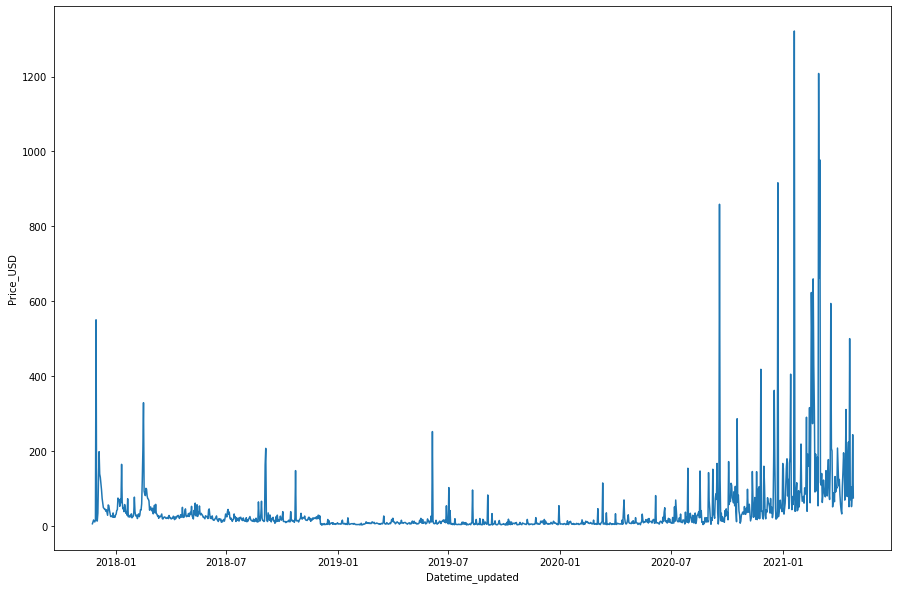

In [47]:
plt.figure(figsize=(15,10))
sns.lineplot(data=sum_kitties, x="Datetime_updated", y="Price_USD")